# Generating V3 Datasets

# Initial Setup

## Jupyter Extensions

Load [watermark](https://github.com/rasbt/watermark) to see the state of the machine and environment that's running the notebook. To make sense of the options, take a look at the [usage](https://github.com/rasbt/watermark#usage) section of the readme.

In [1]:
# Load `watermark` extension
%load_ext watermark

In [2]:
# Display the status of the machine and other non-code related info
%watermark -m -g -b -h

Compiler    : GCC 13.3.0
OS          : Linux
Release     : 6.14.0-22-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 22
Architecture: 64bit

Hostname: thousand-sunny-kbnt

Git hash: 3478498f546efa4b6e547b5e86b28266bb557b6f

Git branch: mbb



Load [autoreload](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html) which will always reload modules marked with `%aimport`.

This behavior can be inverted by running `autoreload 2` which will set everything to be auto-reloaded *except* for modules marked with `%aimport`.

In [3]:
# Load `autoreload` extension
%load_ext autoreload

In [4]:
# Set autoreload behavior
%autoreload 1

Load `matplotlib` in one of the more `jupyter`-friendly [rich-output modes](https://ipython.readthedocs.io/en/stable/interactive/plotting.html). Some options (that may or may not have worked) are `inline`, `notebook`, and `gtk`.

In [5]:
# Set the matplotlib mode
%matplotlib inline

## Imports

In [6]:
# Standard library imports
import pickle
from pathlib import Path
from datetime import datetime

# Third party
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%aimport hmdcpd.visualization
%aimport hmdcpd.analysis
from hmdcpd import (
    visualization,
    analysis,
)

%aimport bouncing_ball_task.bouncing_ball
%aimport bouncing_ball_task.human_bouncing_ball.dataset
%aimport bouncing_ball_task.human_bouncing_ball.catch
%aimport bouncing_ball_task.human_bouncing_ball.straight
%aimport bouncing_ball_task.human_bouncing_ball.bounce
%aimport bouncing_ball_task.human_bouncing_ball.nonwall
%aimport bouncing_ball_task.human_bouncing_ball.defaults
%aimport bouncing_ball_task.utils.pyutils
%aimport bouncing_ball_task.utils.taskutils
%aimport bouncing_ball_task.utils.visualize
%aimport bouncing_ball_task.utils.gif
from bouncing_ball_task.utils import pyutils, visualize, htaskutils
from bouncing_ball_task import index
import bouncing_ball_task.human_bouncing_ball.dataset as hbb
from bouncing_ball_task.human_bouncing_ball import defaults

# Display  versions of everything
%watermark -v -iv

Python implementation: CPython
Python version       : 3.13.5
IPython version      : 9.3.0

numpy             : 2.3.0
torch             : 2.6.0
seaborn           : 0.13.2
pandas            : 2.3.0
matplotlib        : 3.10.3
bouncing_ball_task: 0.0.0



In [7]:
# Figures
default_fig_size = (10, 5)
default_fig_size_smaller = (8, 5)
default_font_label = 14
default_font_title = 18
default_aspect = default_fig_size[0] / default_fig_size[1]
default_height = default_fig_size[1]
dpi = 200

# Experiment defaults
default_valid_colors={1: "red", 2: "green", 3: "blue"}

# Color Prediction Plots
color_predition_name_column_dict = {
    "Color Entered": "color_entered",
    "Next Color": "color_next",
    "Third Color": "color_after_next",
}

# Generating the Dataset

In [17]:
## Maximum Task Sensitivity

def compute_slope_and_residuals(group, cwc):
    """Compute slope and residual variance using least squares regression."""
    X = np.vstack([group, np.ones_like(group)]).T  # Design matrix
    slope, intercept = np.linalg.lstsq(X, cwc, rcond=None)[
        0
    ]  # Solve for slope and intercept

    residuals = cwc - (slope * group + intercept)
    residual_var = residuals.var(
        ddof=1
    )  # Use variance inddstead of std to avoid redundant sqrt
    return slope, residual_var


def compute_within_subject_hz_effect_size(
    idx_time,
    cwc,
    index_high,
    index_low,
):
    """Compute within-subject standardized effect size for a single participant."""
    # Compute statistics for high and low conditions
    slope_high, residual_var_high = compute_slope_and_residuals(
        idx_time[index_high], cwc[index_high]
    )
    slope_low, residual_var_low = compute_slope_and_residuals(
        idx_time[index_low], cwc[index_low]
    )
    # Compute slope difference
    slope_diff = slope_high - slope_low

    # Compute pooled standard deviation (avoid redundant sqrt)
    sigma_pooled = np.sqrt((residual_var_high + residual_var_low) / 2)

    # Compute within-subject effect size (Cohen’s d)
    d_within = (
        slope_diff / sigma_pooled if sigma_pooled > 0 else np.nan
    )  # Avoid division by zero

    return {
        "slope_high": slope_high,
        "slope_low": slope_low,
        "slope_diff": slope_diff,
        "residual_var_high": residual_var_high,
        "residual_var_low": residual_var_low,
        "sigma_pooled": sigma_pooled,
        "d_within": d_within,
    }


def compute_within_subject_cont_effect_size(
    pccovc,
    cwc,
    index_bounce,
):
    """Compute within-subject standardized effect size for a single participant."""
    # Compute statistics for high and low conditions
    slope, residual_var = compute_slope_and_residuals(
        pccovc,
        cwc[index_bounce],
    )

    # Compute standardized effect size (Cohen’s d)
    sigma = np.sqrt(residual_var)
    d_within = (
        slope / sigma if sigma > 0 else np.nan
    )  # Avoid division by zero

    return {
        "slope": slope,
        "residual_var": residual_var,
        "d_within": d_within,
    }

def plot_effective_stats(df_data):
    # Create the subplots
    palette = visualization.get_color_palette(
        ["Low", "High"],
        (("Blues", 1), ("Reds", 1)),
        linspace_range=(0.75, 1),
    )
    palette_trial = visualization.get_color_palette(
        ["Catch", "Straight", "Nonwall", "Bounce"],
        (("Greens", 1), ("Blues", 1), ("Wistia", 1), ("Reds", 1)),
        linspace_range=(0.75, 1),
    )
    palette_contingency = visualization.get_color_palette(
        ["Low", "Medium", "High"],
        (("Blues", 1), ("Wistia", 1), ("Reds", 1)),
        linspace_range=(0.75, 1),
    )

    plot_params = [
        [
            (
                "PCCNVC_effective",
                "Observed Hazard Rates",
                "Effective Hazard Rate Bins",
                {
                    "hue": "Hazard Rate",
                    "legend": True,
                    "palette": palette,
                    "multiple": "stack",
                }
            ),
            (
                "PCCOVC_effective",
                "Observed Trial Contingency",
                "Effective Contingency Bins",
                {
                    "hue": "Contingency",
                    "palette": palette_contingency,
                    "legend": True,
                    "multiple": "stack",
                },
            ),
            (
                "PVC_effective",
                "Observed Trial Random Bounce",
                "Effective Random Bounce Bins",
                {
                    "hue": "trial",
                    "palette": palette_trial,
                    "legend": True,
                    "multiple": "stack",
                },
            ),
            (
                "length",
                "Distribution of Video Lengths",
                "Video Length Bins",
                {
                    "hue": "trial",
                    "legend": True,
                    "palette": palette_trial,
                    "multiple": "stack",
                }
            ),
        ],
        [
            (
                "Color Change Random",
                "Number of Random Color Changes",
                "Random Color Change Bins",
                {
                    "hue": "Hazard Rate",
                    "legend": False,
                    "discrete": True,
                    "palette": palette,
                    "multiple": "stack",
                }
            ),
            (
                "Color Change Bounce",
                "Number of Bounce Color Changes",
                "Bounce Color Changes",
                {
                    "discrete": True,
                    "hue": "Contingency",
                    "palette": palette_contingency,
                    "legend": False,
                    "multiple": "stack",
                }
            ),
            (
                "Random Bounces",
                "Number of Random Bounces",
                "Number of Random Bounces",
                {
                    "discrete": True,
                    "hue": "trial",
                    "palette": palette_trial,
                    "legend": False,
                    "multiple": "stack",
                }
            ),
            (
                "Bounces",
                "Number of Wall Bounces",
                "Number of Wall Bounces",
                {
                    "discrete": True,
                    "hue": "trial",
                    "palette": palette_trial,
                    "legend": True,
                    "multiple": "stack",
                }
            ),
        ],
    ]

    rows = 2
    fig, axes = plt.subplots(
        rows,
        len(plot_params[0]),
        figsize=(len(plot_params[0])*4, rows*4),
    )

    for i, row_plots in enumerate(plot_params):
        for j, (col, title, xlabel, plot_dict) in enumerate(row_plots):
            ax = axes[i, j]
            sns.histplot(
                df_data,
                x=col,
                ax=ax,
                **plot_dict,
            )
            ax.set_title(title)
            ax.set_xlabel(xlabel)
            if j != 0:
                ax.set_ylabel(None)

    plt.suptitle(f"Task Statstics for {batch_size} Videos")
    plt.tight_layout()

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


{'slope_high': np.float64(0.5337021600967448),
 'slope_low': np.float64(0.22493945119656927),
 'slope_diff': np.float64(0.3087627089001755),
 'residual_var_high': np.float64(0.14225284098649546),
 'residual_var_low': np.float64(0.1394052135231642),
 'sigma_pooled': np.float64(0.37527193773959416),
 'd_within': np.float64(0.822770577411066)}

2025-06-28 17:37:55.073 | DEBUG    | bouncing_ball_task.bouncing_ball:color_mask_mode:511 - Running color_mask_mode setter
2025-06-28 17:37:55.074 | DEBUG    | bouncing_ball_task.bouncing_ball:transitioning_change_mode:489 - Running transitioning_change_mode setter
2025-06-28 17:37:55.074 | DEBUG    | bouncing_ball_task.bouncing_ball:sequence_mode:441 - Running sequence_mode setter
2025-06-28 17:37:55.075 | DEBUG    | bouncing_ball_task.bouncing_ball:resample_change_probabilities:537 - Running resample_change_probabilities
2025-06-28 17:37:55.076 | DEBUG    | bouncing_ball_task.bouncing_ball:color_sampling:418 - Running color_sampling setter
2025-06-28 17:37:55.077 | DEBUG    | bouncing_ball_task.bouncing_ball:return_change_mode:475 - Running return_change_mode setter
2025-06-28 17:37:55.095 | DEBUG    | bouncing_ball_task.bouncing_ball:color_mask_mode:511 - Running color_mask_mode setter
2025-06-28 17:37:55.096 | DEBUG    | bouncing_ball_task.bouncing_ball:transitioning_change_mode:48

Dataset Generation Summary
  Num Total Trials: 181 (34 min 38.6 sec)
    ball_radius:                         10
    dt:                                  0.1
    duration:                            50
    exp_scale:                           5
    border_tolerance_outer:              1.25
    mask_center:                         0.5
    mask_fraction:                       0.3333333333333333
    size_x:                              256
    size_y:                              256
    num_pos_x_endpoints:                 3
    num_pos_y_endpoints:                 8
    y_pos_multiplier:                    8
    pvc:                                 0.075
    num_y_velocities:                    2
    bounce_offset:                       0.4
    border_tolerance_inner:              0.1
    num_pos_x_linspace_bounce:           5
    idx_linspace_bounce:                 0
    bounce_timestep:                     5
    repeat_factor:                       3
    seed:                        

/home/apra/Work/Bouncing-Ball-Task/src/bouncing_ball_task/human_bouncing_ball/dataset.py:578: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for val, df_group in df_data.groupby(group):
/home/apra/Work/Bouncing-Ball-Task/src/bouncing_ball_task/human_bouncing_ball/dataset.py:578: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for val, df_group in df_data.groupby(group):
/tmp/ipykernel_273132/2928284583.py:182: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future def

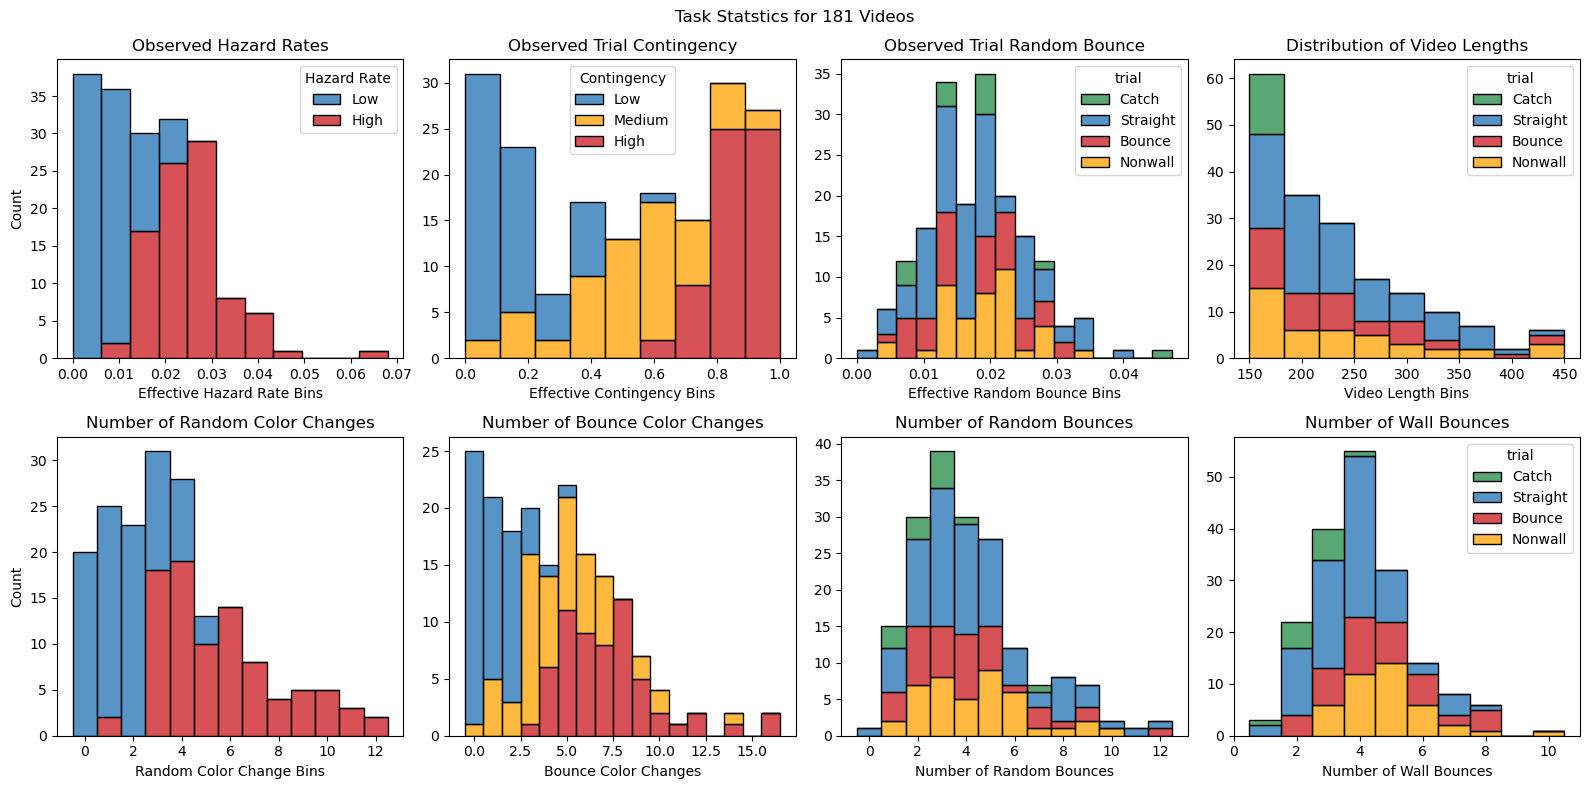

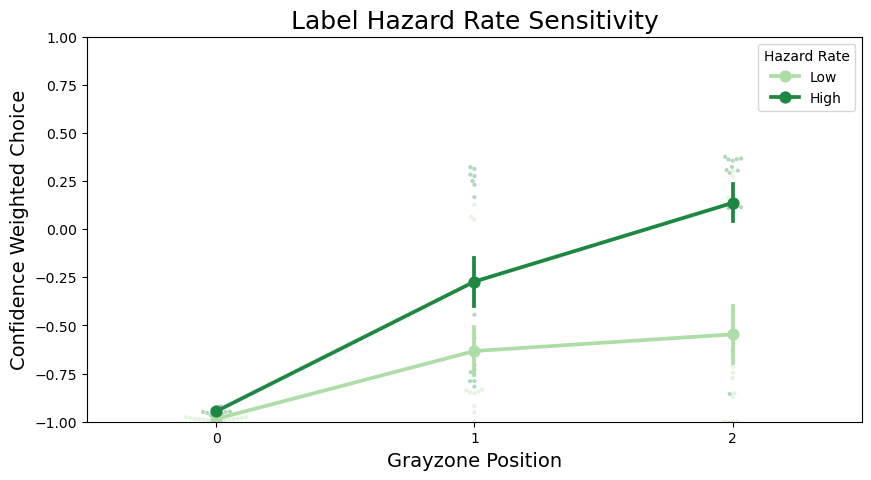

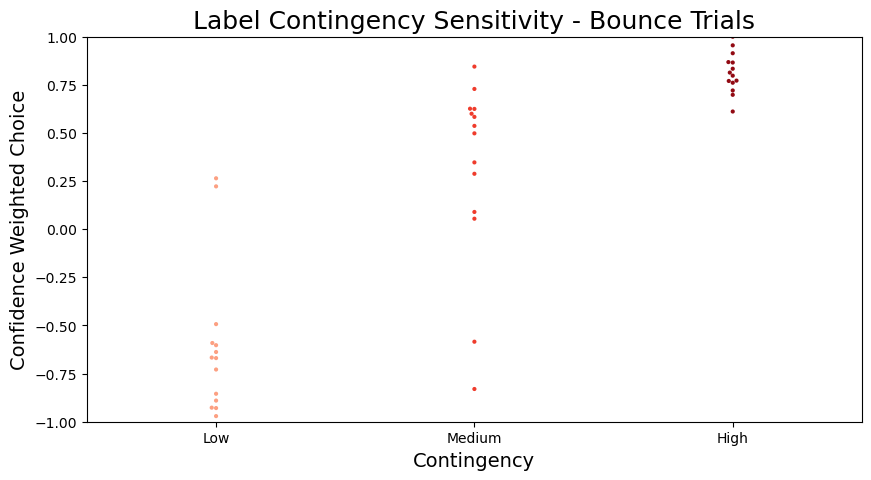

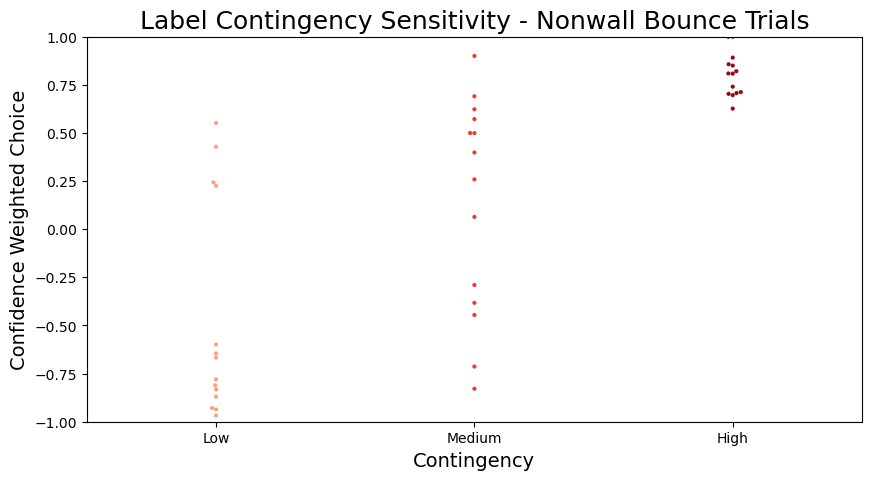

In [24]:
# Seed
seed = pyutils.set_global_seed(467696137)

task_parameters = defaults.task_parameters.asdict
human_dataset_parameters = defaults.human_dataset_parameters.asdict
task_parameters["seed"] = human_dataset_parameters["seed"] = seed

human_dataset_parameters["velocity_lower"] = 0.0975
human_dataset_parameters["velocity_upper"] = 0.1125
human_dataset_parameters["pvc"] = 0.075

# human_dataset_parameters["velocity_lower"] = 0.08
# human_dataset_parameters["velocity_upper"] = 2/15

human_dataset_parameters["pccnvc_lower"] = 0.015
human_dataset_parameters["pccnvc_upper"] = 0.05
human_dataset_parameters["pccovc_lower"] = 0.125
human_dataset_parameters["pccovc_upper"] = 0.875
human_dataset_parameters["video_length_min_s"] = 7.5
human_dataset_parameters["transition_tol"] = 1
human_dataset_parameters["num_blocks"] = 10

human_dataset_parameters["border_tolerance_inner"] = 0.1
# human_dataset_parameters["total_dataset_length"] = 350
human_dataset_parameters["duration"] = 50
human_dataset_parameters["exp_scale"] = 5

human_dataset_parameters["trial_type_split"] =  (0.05, -2, -1, -1)
# human_dataset_parameters["min_t_color_change_after_bounce"] = 45
# human_dataset_parameters["min_t_color_change_after_random"] = 500
# human_dataset_parameters["min_t_velocity_change_after_bounce"] = 75
# human_dataset_parameters["min_t_velocity_change_after_random"] = 160

task_parameters["warmup_t_no_rand_velocity_change"] = 30
task_parameters["warmup_t_no_rand_color_change"] = 2

task_parameters["min_t_color_change_after_bounce"] = 10
task_parameters["min_t_color_change_after_random"] = 10
task_parameters["min_t_velocity_change_after_bounce"] = 30
task_parameters["min_t_velocity_change_after_random"] = 10

# print(human_dataset_parameters["warmup_t_no_rand_velocity_change"])

task, samples, targets, df_data, dict_metadata = hbb.generate_video_dataset(
    human_dataset_parameters,
    task_parameters,
    hbb.dict_trial_type_generation_funcs,
    shuffle=False,
)

if not (variable_length := human_dataset_parameters["variable_length"]):
    try:
        samples = torch.from_numpy(samples)
        targets = torch.from_numpy(targets)
    except TypeError:
        pass
    batch_size, timesteps, _ = samples.shape

else:
    try:
        samples = [torch.from_numpy(sample) for sample in samples]
        targets = [torch.from_numpy(target) for target in targets]
    except TypeError:
        pass

    batch_size = len(samples)
    timesteps = torch.from_numpy(df_data.length.values)

pccnvc_effective = torch.from_numpy(df_data.PCCNVC_effective.to_numpy())
pccovc_effective = torch.from_numpy(df_data.PCCOVC_effective.to_numpy())
pvc_effective = torch.from_numpy(df_data.PVC_effective.to_numpy())
correct_response = torch.from_numpy(df_data.correct_response.to_numpy()) - 1
color_entered = torch.from_numpy(df_data.color_entered.to_numpy()) - 1
color_after_next = torch.from_numpy(df_data.color_after_next.to_numpy()) - 1
color_entered_rgb = torch.eye(3)[color_entered]

last_visible_idx = torch.from_numpy(df_data.last_visible_color_idx.values)
timesteps_to_end = torch.from_numpy(df_data.length.values) - last_visible_idx

if not variable_length:
    timesteps_idx = torch.arange(timesteps).repeat((batch_size, 1))
    mask_last_timesteps = timesteps_idx > last_visible_idx.unsqueeze(-1)
    bounce_last_timesteps = (mask_last_timesteps & targets[:, :, 5:7].any(dim=-1)).any(dim=-1)
else:
    timesteps_idx = [torch.arange(t) for t in timesteps]
    mask_last_timesteps = [timesteps_idx[i] > last_visible_idx[i] for i in range(batch_size)]
    bounce_last_timesteps = torch.stack([
        (mask & target[:, 5:7].any(dim=-1)).any(dim=-1)
        for mask, target in zip(mask_last_timesteps, targets)
    ])

# Subtract a timestep for the bounce since random changes cannot happen
timesteps_random_change = timesteps_to_end - bounce_last_timesteps.int()

# Transition matrix for random changes
third = torch.zeros_like(pccnvc_effective)
T_ccr = torch.stack(
    [
        torch.stack([1 - pccnvc_effective, pccnvc_effective, third], dim=-1),
        torch.stack([third, 1 - pccnvc_effective, pccnvc_effective], dim=-1),
        torch.stack([pccnvc_effective, third, 1 - pccnvc_effective], dim=-1),
    ],
    dim=1,
)

max_exponent = int(timesteps_random_change.max().item())

# Precompute all powers from 0 to max_exponent.
# For k = 0, use the identity matrix.
I = torch.eye(T_ccr.shape[-1])
T_ccr_powers = []
for k in range(max_exponent + 1):
    if k == 0:
        # Expand identity to shape [B, 3, 3]
        T_ccr_powers.append(I.unsqueeze(0).expand(batch_size, -1, -1))
    else:
        T_ccr_powers.append(torch.matrix_power(T_ccr, k))
# Stack into a tensor of shape [max_exponent+1, B, 3, 3]
T_ccr_powers = torch.stack(T_ccr_powers, dim=0)
T_ccr_exp = T_ccr_powers[timesteps_random_change, torch.arange(batch_size), :, :].float()

# Apply random color transitions
belief_oracle = torch.bmm(color_entered_rgb.unsqueeze(1), T_ccr_exp).squeeze(1)

# Transition for bounces
T_ccb = torch.stack(
    [
        torch.stack([1 - pccovc_effective, pccovc_effective, third], dim=-1),
        torch.stack([third, 1 - pccovc_effective, pccovc_effective], dim=-1),
        torch.stack([pccovc_effective, third, 1 - pccovc_effective], dim=-1),
    ],
    dim=1,
).float()
belief_oracle[bounce_last_timesteps] = torch.bmm(
    belief_oracle[bounce_last_timesteps].unsqueeze(1),
    T_ccb[bounce_last_timesteps],
).squeeze(1)

labels_coded = torch.where(color_entered == correct_response, -1, 1)
# labels_coded[labels_coded == 1] = torch.where(
#     correct_response[labels_coded == 1] == color_after_next[labels_coded == 1],
#     2,
#     1,
# )
labels_prob = belief_oracle[torch.arange(batch_size), correct_response]
labels_weighted = (labels_coded * labels_prob).numpy()
df_data["cwl"] = labels_weighted

df_straight = df_data[df_data["trial"] == "Straight"]
df_bounce = df_data[df_data["trial"] == "Bounce"]
df_nonwall = df_data[df_data["trial"] == "Nonwall"]

effect_hz_ico = compute_within_subject_hz_effect_size(
    df_data.idx_time.to_numpy(),
    labels_weighted,
    df_straight[df_straight["Hazard Rate"] == "High"].index,
    df_straight[df_straight["Hazard Rate"] == "Low"].index,
)

effect_cont_ico_bounce = compute_within_subject_cont_effect_size(
    df_bounce.PCCOVC.to_numpy(),
    labels_weighted,
    df_bounce.index,
)

effect_cont_ico_nonwall = compute_within_subject_cont_effect_size(
    df_nonwall.PCCOVC.to_numpy(),
    labels_weighted,
    df_nonwall.index,
)
print(f"Labels Straight - High Hz Slope: {effect_hz_ico['slope_high']}")
print(f"Labels Straight - Low Hz Slope: {effect_hz_ico['slope_low']}")
print(f"Labels Straight - Hz Slope Diff: {effect_hz_ico['slope_diff']}")
print(f"Labels Bounce - Cont Slope: {effect_cont_ico_bounce['slope']}")
print(f"Labels Nonwall - Cont Slope: {effect_cont_ico_nonwall['slope']}")
print(f"No Change Split: {(color_entered == correct_response).float().mean()}")

print(f"Bounces: {df_data.Bounces.sum()}")
print(f"Nonwall Bounces: {df_data['Random Bounces'].sum()}")

dict_hz = {}
for hz, df_hz in df_straight.groupby("Hazard Rate"):
    dict_hz[hz] = {}
    for pos, df_pos in df_hz.groupby("idx_time"):
        dict_hz[hz][pos] = (df_pos.color_entered == df_pos.correct_response).mean()

print(f"Low HZ -- {dict_hz['Low'][0]:.2f} -- {dict_hz['Low'][1]:.2f} -- {dict_hz['Low'][2]:.2f}")
print(f"High HZ -- {dict_hz['High'][0]:.2f} -- {dict_hz['High'][1]:.2f} -- {dict_hz['High'][2]:.2f}")

plot_effective_stats(df_data)
ylim = (-1, 1.0)

visualization.multi_plot_color_prediction_counts(
    df_straight,
    "Label Hazard Rate Sensitivity",
    hue="Hazard Rate",
    x="idx_time",
    y="cwl",
    ylabel="Confidence Weighted Choice",
    xlabel="Grayzone Position",
    ylim=ylim,
    palette_labels=["Low", "High"],
    palette_color_counts=(("Greens", 2),),
    palette_linspace_range=(0.333, 1.2),
)

visualization.multi_plot_color_prediction_counts(
    df_bounce,
    "Label Contingency Sensitivity - Bounce Trials",
    hue="Contingency",
    x="Contingency",
    y="cwl",
    ylabel="Confidence Weighted Choice",
    ylim=ylim,
    palette_labels=['Low', 'Medium', 'High'],
    palette_color_counts=(("Reds", 3),),
    palette_linspace_range=(0.333, 1.2),
    plot_2=None,
    no_legend=True,
)

visualization.multi_plot_color_prediction_counts(
    df_nonwall,
    "Label Contingency Sensitivity - Nonwall Bounce Trials",
    hue="Contingency",
    x="Contingency",
    y="cwl",
    ylabel="Confidence Weighted Choice",
    ylim=ylim,
    palette_labels=['Low', 'Medium', 'High'],
    palette_color_counts=(("Reds", 3),),
    palette_linspace_range=(0.333, 1.2),
    plot_2=None,
    no_legend=True,
)

plt.show()

# Saving the Dataset

In [22]:
task_parameters["batch_size"] = len(df_data)
dict_metadata["task_parameters"] = task_parameters
dict_metadata["human_dataset_parameters"] = human_dataset_parameters
dict_metadata["name"] = name_dataset = htaskutils.generate_dataset_name(
    defaults.name_dataset,
    seed=dict_metadata["seed"],
)
print(dict_metadata["name"])
dir_base = index.dir_repo/"data/hmdcpd"
dryrun = False

path_videos = hbb.save_video_dataset(
    dir_base,
    name_dataset,
    df_data,
    dict_metadata,
    samples,
    targets,
    task,
    duration=human_dataset_parameters["duration"],
    mode=defaults.mode,
    multiplier=2,
    save_target=True,
    save_animation=True,
    display_animation=defaults.display_animation,
    num_sequences=1,
    as_mp4=True,
    include_timestep=defaults.include_timestep,
    return_path=True,
    dryrun=dryrun,
)

2025-06-28 17:28:39.073 | INFO     | bouncing_ball_task.human_bouncing_ball.dataset:save_video_dataset:9 - Saving dataset to /home/apra/Work/Bouncing-Ball-Task/data/hmdcpd/hbb_dataset_250628_172839_467696137 (dir_dataset)
2025-06-28 17:28:39.074 | INFO     | bouncing_ball_task.human_bouncing_ball.dataset:save_video_dataset:16 - Saving trial metadata to to /dir_dataset/trial_meta
2025-06-28 17:28:39.081 | INFO     | bouncing_ball_task.human_bouncing_ball.dataset:save_video_dataset:24 - Saving dataset metadata to to /dir_dataset/dataset_meta
2025-06-28 17:28:39.083 | DEBUG    | bouncing_ball_task.human_bouncing_ball.dataset:save_video_dataset:58 - Generating video files in /dir_dataset/videos/{dir_block.stem}/{dir_video.stem}


hbb_dataset_250628_172839_467696137


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'
2025-06-28 17:28:39.517 | DEBUG    | bouncing_ball_task.human_bouncing_ball.dataset:save_video_dataset:58 - Generating video files in /dir_dataset/videos/{dir_block.stem}/{dir_video.stem}
OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'
2025-06-28 17:28:39.908 | DEBUG    | bouncing_ball_task.human_bouncing_ball.dataset:save_video_dataset:58 - Generating video files in /dir_dataset/videos/{dir_block.stem}/{dir_video.stem}
OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'
2025-06-28 17:28:40.319 | DEBUG    | bouncing_ball_task.human_bouncing_ball.dataset:save_video_dataset:58 - Generating video f

In [12]:
# task_parameters.batch_size

In [14]:
# import pickle
# path_dataset_meta = dir_base / "hbb_dataset_250627_004521_2190033339/dataset_meta.pkl"
# with open(str(path_dataset_meta), "wb") as handle:
#     pickle.dump(dict_metadata, handle)
